In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Raw dataset combination

## Mean temperature feature

There are 12 datasets retrieved on the HKO website for us to predict the mean temperature tomorrow. The data we choose as our features are daily mean pressure, daily rainfall, daily relative humidity, daily mean cloud amount, daily evaporation, daily global solar radiation, daily max UV, daily mean UV, daily prevailing wind direction, daily wind speed, and daily total sunlight. We used a for-loop to read all datasets.

In [ ]:
rdf_list = [
    'CLMeanTEMPerature_HKO_.csv',
    'daily_HKO_MSLP_meanpressure_ALL.csv',
    'daily_HKO_RainFall_ALL.csv',
    'daily_HKO_RelativeHumidity_ALL.csv',
    'daily_HKO_meanCLOUD_ALL.csv',
    'daily_KP_EVAP_ALL.csv',
    'daily_KP_GlobalSolarRadiation_ALL.csv',
    'daily_KP_MAXUV_ALL.csv',
    'daily_KP_PrevailingWindDIRection_ALL.csv',
    'daily_KP_WindSPeeD_ALL.csv',
    'daily_KP_meanUV_ALL.csv',
    'daily_KP_totalSUNlight_ALL.csv',
]

def read_csv_files(rdf_list, skiprows=2):
    dataframesrdf = {}
    for i, file_name in enumerate(rdf_list, 1):
        df_name = f'rdf{i}'
        dataframesrdf[df_name] = pd.read_csv(file_name, skiprows=skiprows)
        print(f"Successfully loaded {file_name} into {df_name}")
    return dataframesrdf

dataframesrdf = read_csv_files(rdf_list)

In [ ]:
for i in range(1, len(dataframesrdf) + 1):
    globals()[f'rdf{i}'] = dataframesrdf[f'rdf{i}']

Since each dataset contains a “數值/Value” column about their own data, we then changed all the “數值/Value” to their corresponding data name.

In [ ]:
value_name = {
    'rdf1': 'Mean Temperature',
    'rdf2': 'Mean Pressure',
    'rdf3': 'Rainfall',
    'rdf4': 'Relative Humidity',
    'rdf5': 'Mean Cloud',
    'rdf6': 'Evaporation',
    'rdf7': 'Global Solar Radiation',
    'rdf8': 'Max UV',
    'rdf9': 'Prevailing Wind Direction',
    'rdf10': 'Wind Speed',
    'rdf11': 'Mean UV',
    'rdf12': 'Total Sunlight',
}

# Loop through the dictionary to rename columns
for df_name, new_name in value_name.items():
    globals()[df_name].rename(columns={'數值/Value': new_name}, inplace=True)

## Merged raining feature data

After getting the correct column names, we merged all HKO data into one large dataset on the “Year”, “Month”, “Day” columns. The large dataset HKO we created has 4 uninformative rows. We then use the iloc function to remove them.

In [ ]:
hko = dataframesrdf['rdf1'][['年/Year', '月/Month', '日/Day', 'Mean Temperature']].copy()
for i in range(2, len(dataframesrdf) + 1):
    df = dataframesrdf[f'rdf{i}']
    value_col = df.columns[~df.columns.isin(['年/Year', '月/Month', '日/Day', 'Date'])][0]
    hko = hko.merge(
        df[['年/Year', '月/Month', '日/Day', value_col]],
        on=['年/Year', '月/Month', '日/Day'],
        how='outer'
    )
hko = hko.sort_values(['年/Year', '月/Month', '日/Day']).reset_index(drop=True)

In [ ]:
hko

In [ ]:
hko = hko.iloc[2:-2]
hko

## Air pollutant

There are 4 datasets retrieved on the Environmental Protection Department website. All of them have the same features. The only difference is the time they covered. 

In [ ]:
ap_list = [
    'air_daily_mongkok1990_1994.csv',
    'air_daily_mongkok1994_2004.csv',
    'air_daily_mongkok2004_2014.csv',
    'air_daily_mongkok2014_2024.csv',
]

def read_csv_files(ap_list, skiprows=11):
    dataframesap = {}
    for i, file_name in enumerate(ap_list, 1):
        df_name = f'ap{i}'   
        dataframesap[df_name] = pd.read_csv(file_name, skiprows=skiprows)
        print(f"Successfully loaded {file_name} into {df_name}")
    return dataframesap

dataframesap = read_csv_files(ap_list)

for i in range(1, len(dataframesap) + 1):
    globals()[f'ap{i}'] = dataframesap[f'ap{i}']

## Merged Air pollutant

Therefore, after reading all 4 datasets, we use the concat function to combine them, while assuring the order of the date. The large dataset ap is formed.

In [ ]:
ap = pd.concat([ap1, ap2, ap3, ap4], ignore_index=True)
ap.reset_index(drop=True, inplace=True)
ap

## Typhoon

There are 4 datasets retrieved on the Tropical Cyclone Warning Signals website of HKO. The features we are interested in are “Intensity”, “Signal”, “Start Date”, and “Duration (hr min)”. The dataset is named as ty. The shape of ty is 547 times 8. The data type of its columns is mostly string.

In [ ]:
ty = pd.read_csv('typhoon.csv', header= 0)
ty

# Merging Dataset

## Mean Temperature Feature

In [ ]:
hko = hko.rename(columns={'年/Year': 'Year', '月/Month': 'Month', '日/Day': 'Day'})
hko['Month'] = hko['Month'].astype(int)
hko['Month'] = hko['Month'].apply(lambda x: f'0{x}' if 0 < x < 10 else x)
hko['Day'] = hko['Day'].astype(int)
hko['Day'] = hko['Day'].apply(lambda x: f'0{x}' if 0 < x < 10 else x)
hko['Date'] = hko[['Day','Month','Year']].astype(str).agg('-'.join, axis=1)
hko['Dateymd'] = hko[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1)
hko = hko.sort_values(by='Dateymd', ascending=True).reset_index(drop=True)
print(hko.shape)

In [ ]:
hko

## Air Pollutant

In [ ]:
ap.rename(columns={'DATE': 'Date'}, inplace=True)
print(ap.shape)

In [ ]:
ap

## Typhoon

In [ ]:
def change_abbrev(x):
    x = x.lower()
    month_abbrev_to_num = {
        "jan": 1,
        "feb": 2,
        "mar": 3,
        "apr": 4,
        "may": 5,
        "jun": 6,
        "jul": 7,
        "aug": 8,
        "sep": 9,
        "oct": 10,
        "nov": 11,
        "dec": 12
    }
    return month_abbrev_to_num.get(x)


def change_year(x):
    x = str(x)
    if x.startswith('9'):
        return int('19'+x)
    return int('20'+x)


def change_intensity(x):
    intensity_to_num = {
        "Tropical Depression": 1,
        "Tropical Depression/Tropical Depression": 1,
        "Tropical Storm": 2,
        "Severe Tropical Storm": 3,
        "Typhoon": 4,
        "Typhoon (Severe Typhoon)": 5,
        "Severe Typhoon": 5,
        "Typhoon (Super Typhoon)": 6,
        "Super Typhoon": 6
    }
    return intensity_to_num.get(x)


def change_signal(x):
    x = str(x)
    signal_to_num = {
        "1": 1,
        "3": 2,
        "8 NE": 3,
        "8 SE": 3,
        "8 NW": 3,
        "8 SW": 3,
        "9": 4,
        "10": 5

    }
    return signal_to_num.get(x)


def change_dur(x):
    hr = int(x.split(" ")[0])
    mins = int(x.split(" ")[1])
    return hr * 60 + mins

In [ ]:
ty["Year"] = ty["Start Date"].map(lambda x: x.split('-')[2])
ty["Month"] = ty["Start Date"].map(lambda x: x.split('-')[1])
ty["Day"] = ty["Start Date"].map(lambda x: x.split('-')[0])

ty["Month"] = ty["Month"].apply(change_abbrev)
ty["Year"] = ty["Year"].apply(change_year)
ty['Intensity'] = ty['Intensity'].apply(change_intensity)
ty['Signal'] = ty['Signal'].apply(change_signal)
ty['Duration(hr min)'] = ty['Duration(hr min)'].apply(change_dur)

# print(df.Signal.unique())
ty = ty[['Year', 'Month', 'Day', 'Intensity', 'Signal', "Duration(hr min)"]]
ty[['Year', 'Month', 'Day']] = ty[['Year', 'Month', 'Day']].astype('int')
ty = ty.groupby(['Year', 'Month', 'Day']).agg({'Intensity': 'max',
                                                          'Signal': 'max',
                                                          'Duration(hr min)': 'sum',}).reset_index()



In [ ]:
ty

# Merged unclean dataset

In [ ]:
rawdf = pd.merge(hko, ap, on='Date', how='right')
rawdf[['Year', 'Month', 'Day']] = rawdf[['Year', 'Month', 'Day']].astype('int')
unclean_output = pd.merge(rawdf, ty, on=['Year', 'Month', 'Day'], how='left')
unclean_output.drop(['Date', 'STATION'], axis=1, inplace=True)
unclean_output['Tmr Mean Temperature'] = unclean_output['Mean Temperature'].shift(-1)

In [ ]:
unclean_output

# Data describtion of unclean dataset

## Column Name Explaination

Mean Temperature : Data on daily mean temperatures (degree C) 

Mean Cloud : Data on daily mean amount of cloud (%) 

Mean Pressure : Data on daily mean pressure (hPa) 

Rainfall : Data on daily total rainfall (mm) 

Relative Humidity : Data on daily mean relative humidity (%) 

Evaporation : Data on daily total evaporation (mm) 

Global Solar Radiation : Data on daily global solar radiation (MJ/m^2) 

Max UV : Data on daily maximum UV indices (UV index) 

Mean UV : Data on daily mean UV indices (UV index) 

Prevailing Wind Direction : Data on daily prevailing wind direction (degree) 

Total Sunlight : Data on daily total bright sunshine (hours) 

Wind Speed : Data on daily mean wind speed (km/h) 

SO2 : Daily mean of Sulpher Dioxide measured in Mong Kok station (μg/m3) 

NOX : Daily mean of Nitrogen Oxides measured in Mong Kok station (μg/m3) 

NO2 : Daily mean of Nitrogen Dioxide measured in Mong Kok station (μg/m3) 

CO : Daily mean of Carbon Monoxide measured in Mong Kok station (10 μg/m3) 

RSP : Daily mean of Respirable Suspended Particulates measured in Mong Kok station (μg/m3) 

O3 : Daily mean of Ozone measured in Mong Kok station (μg/m3) 

FSP : Daily mean of Fine Suspended Particulates measured in Mong Kok station (μg/m3) 


In [ ]:
unclean_output.columns

In [ ]:
unclean_output.shape

In [ ]:
patterns = [('***', 'pat1'), ('Trace', 'pat2'), ('N.A.', 'pat3')]
wrongdata = {}

counts = {i: {} for _, i in patterns}
for pattern, i in patterns:
    wrongdata[i] = unclean_output.where(unclean_output == pattern)
    wrongdata[i] = wrongdata[i].dropna(how='all').reset_index(drop=True)
    counts[i] = wrongdata[i].count().to_dict()

wrongcount = pd.DataFrame(counts)
wrongcount = wrongcount.rename_axis('Feature').reset_index()
print(wrongcount.to_string(index=False))

In [ ]:
finaldfuncleannd = unclean_output.drop(['Year', 'Month', 'Day', 'Dateymd'], axis=1).copy()
finaldfuncleannd = finaldfuncleannd.replace('***', np.nan)
finaldfuncleannd = finaldfuncleannd.replace('Trace', np.nan)
finaldfuncleannd = finaldfuncleannd.replace('N.A.', np.nan)
finaldfuncleannd = finaldfuncleannd.astype(float)

In [ ]:
finaldfuncleannd[['Intensity', 
                  'Signal', 
                  'Duration(hr min)']] = finaldfuncleannd[['Intensity','Signal', 
                                                           'Duration(hr min)']].fillna(0)


In [ ]:
finaldfuncleannd.describe().T

## Correlation matrix

In [ ]:
finaldfuncleanndcorr = finaldfuncleannd.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(finaldfuncleanndcorr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features')
plt.show()

## Unclean Dataset Features Importance

### rainfall check

In [ ]:
data = finaldfuncleannd.copy()
data['tmr rainfall'] = data['Rainfall'].shift(-1)
if 'Prevailing Wind Direction' in data.columns:
    le = LabelEncoder()
    data['Prevailing Wind Direction'] = le.fit_transform(data['Prevailing Wind Direction'].astype(str))

data['tmr rainfall'] = data['tmr rainfall'].fillna(data['tmr rainfall'].mean()) 

target_column = 'tmr rainfall'
X = data.drop(columns=[target_column, 'Rainfall'], axis=1)
y = data[target_column]

rf = RandomForestRegressor(n_estimators=100, random_state=1234)
rf.fit(X, y)

feature_importance = rf.feature_importances_
feature_names = X.columns

importance_df2 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df2)

plt.figure(figsize=(10, 6))
plt.barh(importance_df2['Feature'], importance_df2['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Predicting Rainfall')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### mean temperature check

In [ ]:
data = finaldfuncleannd.copy()
if 'Prevailing Wind Direction' in data.columns:
    le = LabelEncoder()
    data['Prevailing Wind Direction'] = le.fit_transform(data['Prevailing Wind Direction'].astype(str))

data['Tmr Mean Temperature'] = data['Tmr Mean Temperature'].fillna(data['Tmr Mean Temperature'].mean())

target_column = 'Tmr Mean Temperature'
X = data.drop(columns=[target_column, 'Mean Temperature'], axis=1)
y = data[target_column]

rf = RandomForestRegressor(n_estimators=100, random_state=1234)
rf.fit(X, y)

feature_importance = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance for Predicting Mean Temperature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
mergedimportance = pd.merge(importance_df, importance_df2, on='Feature', how='outer')
mergedimportance.sort_values(by='Importance_x', ascending=False, inplace=True)
mergedimportance.reset_index(drop=True)
mergedimportance.rename(columns={'Importance_x': 'Mean Temperature Importance',
                                  'Importance_y': 'Rainfall Importance'}, inplace=True)
mergedimportance

## Histogram

In [ ]:
plt.title('Signal Distribution')
sns.histplot(finaldfuncleannd, x='Signal', bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

In [ ]:
plt.title('Intensity Distribution')
sns.histplot(finaldfuncleannd, x='Intensity', bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])

In [ ]:
plt.title('Rainfall Distribution')
sns.histplot(finaldfuncleannd, x='Rainfall', bins=range(0, 400, 10), kde=True)

In [ ]:
plt.title('Temperature Distribution')
sns.histplot(finaldfuncleannd, x='Mean Temperature', bins=range(0, 40, 5), kde=True)

## Pie chart

In [ ]:
plt.figure(figsize=(15, 6))
plt.title('Prevailing Wind Direction Distribution')
plt.pie(finaldfuncleannd['Prevailing Wind Direction'].value_counts(),
        labels=finaldfuncleannd['Prevailing Wind Direction'].value_counts().index,
        autopct='%1.1f%%',
        startangle=140)
plt.axis('equal')
plt.show()

## Line graph

In [ ]:
for column in finaldfuncleannd.columns:
    plt.figure(figsize=(50, 25))
    plt.plot(unclean_output['Dateymd'], finaldfuncleannd[column], marker='o', linestyle='-', markersize=2)
    plt.title(f'Line Graph of {column} from 1991 to 2024', fontsize=40)
    plt.xlabel('Date', fontsize=25)
    plt.ylabel(column, fontsize=25)
    plt.xticks(rotation=90, fontsize=1)
    plt.grid()
    plt.tight_layout()
    plt.show()

## Box plot

In [ ]:
fig, axes = plt.subplots(12, 2, figsize=(10, 40))
axes = axes.flatten()

for i, col in enumerate(finaldfuncleannd.columns):
    axes[i].boxplot(finaldfuncleannd[col].dropna().astype(float))
    axes[i].set_title(col, fontsize=10)
    axes[i].set_ylabel('Value')
    axes[i].tick_params(axis='x', labelbottom=False)

plt.tight_layout()

plt.savefig('box_plots_numeric_columns.png', dpi=300, bbox_inches='tight')
print("Box plots saved as 'box_plots_numeric_columns.png'")

plt.show()

## Scatter plot

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(10, 10))
axes = axes.flatten()

for i, col in enumerate(finaldfuncleannd.columns):
    axes[i].scatter(finaldfuncleannd[col], finaldfuncleannd['Tmr Mean Temperature'], alpha=0.5)
    axes[i].set_title(f'Tmr Mean Temperature vs {col}', fontsize=5)
    axes[i].set_xlabel(col, fontsize=5)
    axes[i].set_ylabel('Tmr Mean Temperature', fontsize=5)
    axes[i].grid(True)

plt.tight_layout()

plt.savefig('scatter_plots_rainfall.png', dpi=300, bbox_inches='tight')
print("Scatter plots saved as 'scatter_plots_rainfall.png'")

plt.show()

# Final Dataframe

In [ ]:
clean_output = unclean_output.copy().drop('Dateymd', axis=1)
clean_output = clean_output.replace(['***', 'N.A.'], np.nan)
clean_output = clean_output.replace('Trace', 0.05)
clean_output = clean_output.astype(float)
#clean_output.to_csv('clean_output.csv', index=False)

## Filling Missing Value

Refer to Data Cleaning part

In [ ]:
final_df = pd.read_csv('cleaned_dataset.csv', header=0)

In [ ]:
threshold = 0.01
unimportantdf = importance_df[importance_df['Importance']<threshold].copy()
feature_to_drop = unimportantdf['Feature']
dfuncleannddropped = finaldfuncleannd
for i in feature_to_drop:
    dfuncleannddropped = dfuncleannddropped.drop(i, axis=1)

In [ ]:
dfuncleannddropped.columns

In [ ]:
pat = (final_df == '***')|(final_df == 'Trace')|(final_df == 'N.A.')
wrongdata3 = final_df.where(pat)
wrongdata3 = wrongdata3.dropna(how='all').reset_index(drop=True)
wrongdata3.count()

In [ ]:
final_dfwd = final_df.copy()
final_dfwd['Date'] = unclean_output['Dateymd']
final_dfwd

# Data Description

In [ ]:
print(final_df.shape)
final_df.describe()

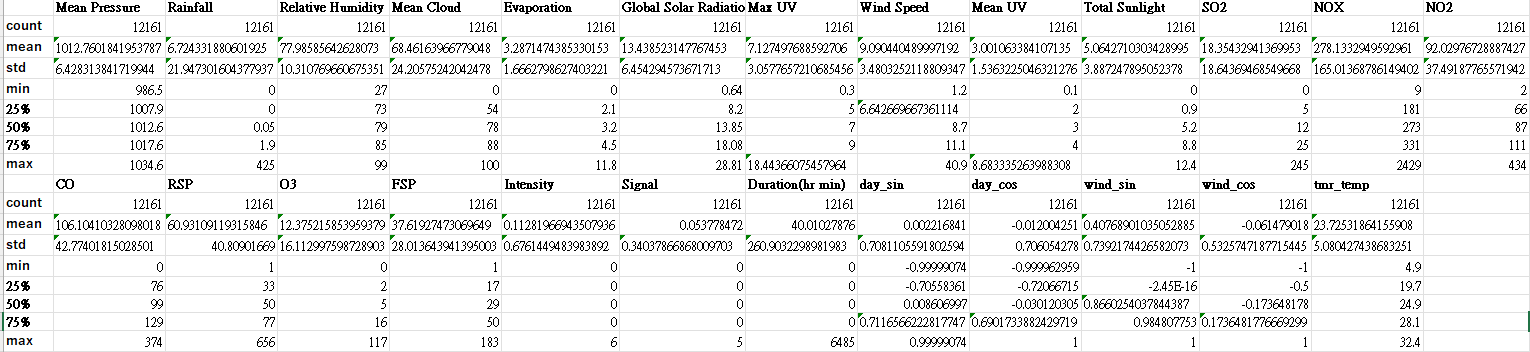

## Correlation matrix

In [ ]:
finaldfnd = final_df.copy()
finaldfndcorr = finaldfnd.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(finaldfndcorr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features')
plt.show()

## Histogram

In [ ]:
sns.histplot(final_df, x='Signal', bins=5)

In [ ]:
sns.histplot(final_df, x='Intensity', bins=5)

## line graph

In [ ]:
for column in final_df.columns:
    plt.figure(figsize=(50, 25))
    plt.plot(final_dfwd['Date'], final_df[column], marker='o', linestyle='-', markersize=2)
    plt.title(f'Line Graph of {column} from 1991 to 2024 of final dataset', fontsize=40)
    plt.xlabel('Date', fontsize=25)
    plt.ylabel(column, fontsize=25)
    plt.xticks(rotation=90, fontsize=1)
    plt.grid()
    plt.tight_layout()
    plt.show()

## box plot

In [ ]:
fig, axes = plt.subplots(13, 2, figsize=(10, 40))
axes = axes.flatten()

for i, col in enumerate(final_df.columns):
    axes[i].boxplot(final_df[col].dropna())
    axes[i].set_title(col, fontsize=10)
    axes[i].set_ylabel('Value')
    axes[i].tick_params(axis='x', labelbottom=False)

plt.tight_layout()

#plt.savefig('box_plots_numeric_columns.png', dpi=300, bbox_inches='tight')
print("Box plots saved as 'box_plots_numeric_columns.png'")

plt.show()

## Scatter plot

In [ ]:
fig, axes = plt.subplots(13, 2, figsize=(10, 40))
axes = axes.flatten()

for i, col in enumerate(final_df.columns):
    axes[i].scatter(final_df[col], final_df['tmr_temp'], alpha=0.5)
    axes[i].set_title(f'Tmr Mean Temperature vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Tmr Mean Temperature')
    axes[i].grid(True)

plt.tight_layout()

#plt.savefig('scatter_plots_rainfall.png', dpi=300, bbox_inches='tight')
print("Scatter plots saved as 'scatter_plots_rainfall.png'")

plt.show()